<a href="https://colab.research.google.com/github/rafaelmatias123/projeto-mochila/blob/main/projeto_rafael_matias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nome : Rafael Matias De Oliveira

Professor: Sérgio Monteiro

Curso : BI & Data Science

Projeto Aplicado : Análise Preditiva e Vantagem Competitiva

Instalando pacotes necessários 


In [157]:
# Instalando o yahoo finance
!pip install yfinance --upgrade --no-cache-dir

!pip install requests



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
%pip install -U mip yfinance requests pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importação dos pacotes necessários

In [159]:
from mip import Model, maximize, xsum, BINARY, OptimizationStatus
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


Coletando os dados reais de ativos no mercado financeiro

In [160]:
url = "https://investnews.com.br/financas/veja-a-lista-completa-dos-bdrs-disponiveis-para-pessoas-fisicas-na-b3/"
r = requests.get(url)
html = r.text
df_bdr = pd.read_html(html, header=0)[0]
df_bdr.head(10)

,EMPRESA,CÓDIGO,SETOR,PAÍS DE ORIGEM
0,3M,MMMC34,Indústria diversificada,EUA
1,AB INBEV,ABUD34,Bebidas,Bélgica
2,ABB LTD,A1BB34,Industrial,Switzerland
3,ABBOTT,ABTT34,Farmacêuticos,EUA
4,ABBVIE,ABBV34,Medicamentos e Outros Produtos,EUA
5,ABIOMED INC,A1BM34,Saúde,EUA
6,ACTIVISION,ATVI34,Tecnologia,EUA
7,ADOBE INC,ADBE34,Tecnologia,EUA
8,ADVANCE AUTO PARTS INC,A1AP34,Peças Automotivas,EUA
9,ADVANCED MIC,A1MD34,Tecnologia,EUA


In [161]:
tickers_ativos = ['BBAS3.SA', 'BBDC4.SA', 'ITUB4.SA', 'SANB11.SA', 'ABCB4.SA', 'A1MD34.SA', 'BPAC11.SA', 'BRSR6.SA', 'ATVI34.SA', 'BPAN4.SA' ]
bdr_lista = yf.download(tickers_ativos, 
                 start='2020-08-01', 
                 end='2023-01-01') [['Close']]
bdr_lista.head()

[*********************100%***********************]  10 of 10 completed


Close                                                          \
            A1MD34.SA   ABCB4.SA   ATVI34.SA   BBAS3.SA   BBDC4.SA  BPAC11.SA   
Date                                                                            
2020-08-03  51.855000  13.777027  453.000000  34.349998  18.347107  22.437500   
2020-08-04  56.173752  13.707596  458.000000  33.299999  17.950413  21.799999   
2020-08-05  56.387501  13.816702  453.290009  33.330002  18.033056  22.049999   
2020-08-06  57.267502  14.044831  462.529999  34.349998  18.157024  22.410000   
2020-08-07  57.712502  13.965482  450.000000  34.110001  18.049585  22.035000   

                                                    
           BPAN4.SA BRSR6.SA   ITUB4.SA  SANB11.SA  
Date                                                
2020-08-03    10.10    14.20  27.280001  29.639999  
2020-08-04     9.85    13.91  25.690001  28.809999  
2020-08-05     9.78    13.74  25.670000  28.900000  
2020-08-06     9.78    14.08  26.030001  29.799999  
2020-08-07     9.74    14.13  25.480000  29.250000

Na etapa de listar as ações peguei o código de 10 bancos, porém dois não estavam listados nesse sistema, então os troquei por 2 da área da tecnologia, como é uma ferramenta para testar, mesmo que influencie ao final, não vejo problema, apesar da volatilidade se comportar de forma diferente muita das vezes entre os segmentos.

Para não precisar replicar esse modelo por 10 vezes, 

In [162]:
bdr = []

for tickers in tickers_ativos:
  bdr.append({'tickers': tickers,
              'lista': bdr_lista['Close'][tickers].values.tolist()
                })

padronizando os dados


In [163]:
#Para 1 ativo = x = np.arange (1,len(y)+1,1)
#Para 10 ativos segue abaixo
x = np.arange (1,len(bdr[0]['lista'])+1,1)

for pad in bdr:
  min = np.min(pad['lista'])
  max = np.max(pad['lista'])
  pad['lista'] = (pad['lista'] - min)/(max - min)
  


Preparação dos conjuntos de dados de treinamento e de teste

In [164]:
teste = {}
treino = {}


for pad in bdr:
  percentual_treinamento = 0.8
  qtd_treinamento = int(percentual_treinamento*(len(x)));

  treino_x = x[0:qtd_treinamento] 
  teste_x = x[qtd_treinamento:]

  treino_y = pad['lista'][0:qtd_treinamento]
  teste_y= pad['lista'][qtd_treinamento:]


  treino[pad['tickers']]= np.array(list(zip(treino_x, treino_y)))
  teste[pad['tickers']]= np.array(list(zip(teste_x, teste_y)))


Seguindo o modelo, agora será feita a organização dos dados

In [165]:

def create_dataset(n_X, look_back):
  dataX = []
  dataY = []
  for i in range(len(n_X)-look_back):
    a = n_X[i:(i+look_back), ]
    print('a: {}'.format(a))
    dataX.append(a)
    dataY.append(n_X[i + look_back, ])
  print('dataX: {}'.format(dataX))
  return np.array(dataX), np.array(dataY)

  

In [166]:
def preparar_dados(dados_serie, look_back):
  X, y =[],[]
  n = len(dados_serie)
  for i in range(n - look_back):
    posicao_fim = i + look_back
    if posicao_fim <= n:
      seq_x = dados_serie[i:posicao_fim,1]
      seq_y = dados_serie[posicao_fim,1]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

Visualização da estruturação dos dados

In [167]:
treino_x = {}
teste_x = {}
treino_y = {}
teste_y = {}


for tickers in tickers_ativos:
  look_back = 2
  local_treino_x, treino_y[tickers] = preparar_dados(treino[tickers], look_back)
  local_teste_x, teste_y[tickers] = preparar_dados(teste[tickers], look_back)

  n_caracteristicas = 1 #série monovariada
  treino_x[tickers] = local_treino_x.reshape((local_treino_x.shape[0], 
                              local_treino_x.shape[1], 
                              n_caracteristicas))
  teste_x[tickers] = local_teste_x.reshape((local_teste_x.shape[0], 
                        local_teste_x.shape[1], 
                        n_caracteristicas))

Criando as redes neurais

In [168]:
modelo = {}

for tickers in tickers_ativos: 
    n_etapas = treino_x[tickers].shape[1]
    n_caracteristicas = treino_x[tickers].shape[2]
    epocas = 20
    n_unidades = 100
    tf.random.set_seed(8888) # Setting seed to ensure reproducibility.
    modelo[tickers] = Sequential()
    camada_de_entrada=(n_etapas , n_caracteristicas)
    modelo[tickers].add(LSTM(n_unidades,  
                  return_sequences = True, 
                  input_shape = camada_de_entrada))
    modelo[tickers].add(Dropout(0.2))
    modelo[tickers].add(LSTM(128,
                  input_shape = camada_de_entrada))
    modelo[tickers].add(Dense(1))

In [169]:
for tickers in tickers_ativos:
  print('\n----------')
  print(tickers)
  print(modelo[tickers].summary())


----------
BBAS3.SA
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 2, 100)            40800     
                                                                 
 dropout_40 (Dropout)        (None, 2, 100)            0         
                                                                 
 lstm_81 (LSTM)              (None, 128)               117248    
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                                 
Total params: 158,177
Trainable params: 158,177
Non-trainable params: 0
_________________________________________________________________
None

----------
BBDC4.SA
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape  

hiperparametros


In [170]:
for tickers in tickers_ativos:
    modelo[tickers].compile(loss = 'mean_squared_error', 
                optimizer = 'adam')

TREINANDO O MODELO


In [171]:
history = {}

for tickers in tickers_ativos:
  history[tickers] = modelo[tickers].fit(treino_x[tickers], treino_y[tickers],
                        epochs = epocas,
                        batch_size = 70,
                        verbose = False,
                        shuffle = False,
                        validation_split = 0.3)

  hist = pd.DataFrame(history[tickers].history)
  hist.head()

In [172]:
for tickers in tickers_ativos:
  print(f'\n{tickers}')
  modelo[tickers].evaluate(teste_x[tickers], teste_y[tickers], batch_size=48)


BBAS3.SA
3/3 [==============================] - 0s 7ms/step - loss: 0.0062

BBDC4.SA
3/3 [==============================] - 0s 4ms/step - loss: 0.0106

ITUB4.SA
3/3 [==============================] - 0s 6ms/step - loss: 0.0028

SANB11.SA
3/3 [==============================] - 0s 4ms/step - loss: 0.0111

ABCB4.SA
3/3 [==============================] - 0s 4ms/step - loss: 0.0053

A1MD34.SA
3/3 [==============================] - 0s 6ms/step - loss: 0.0032

BPAC11.SA
3/3 [==============================] - 0s 4ms/step - loss: 0.0032

BRSR6.SA
3/3 [==============================] - 0s 5ms/step - loss: 0.0160

ATVI34.SA
3/3 [==============================] - 0s 4ms/step - loss: 0.0035

BPAN4.SA
3/3 [==============================] - 0s 6ms/step - loss: 0.0021


Predição do Modelo

In [173]:
predição = {}

for tickers in tickers_ativos:
  predição[tickers] = modelo[tickers].predict(teste_x[tickers])

4/4 [==============================] - 1s 5ms/step


seguindo o modelo de predição 


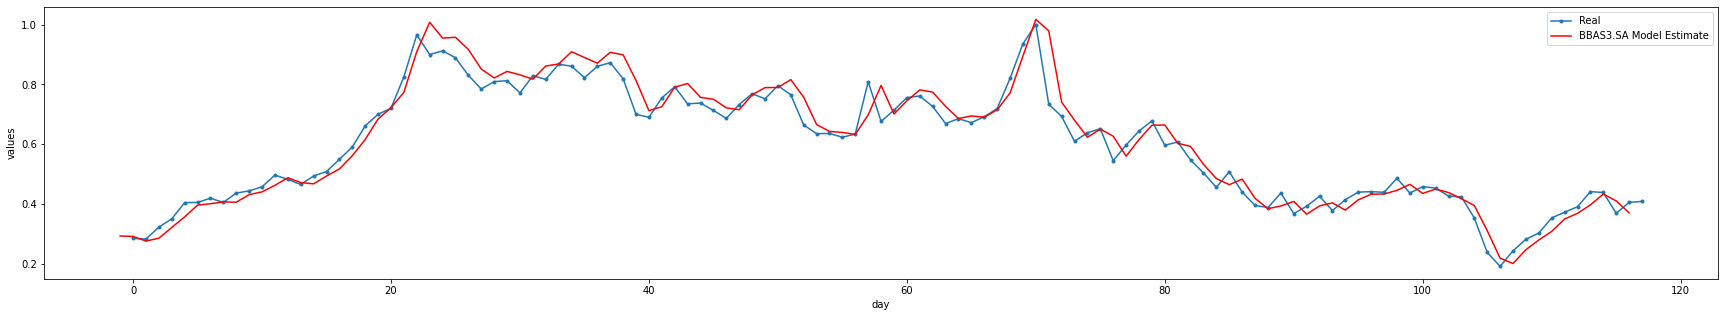

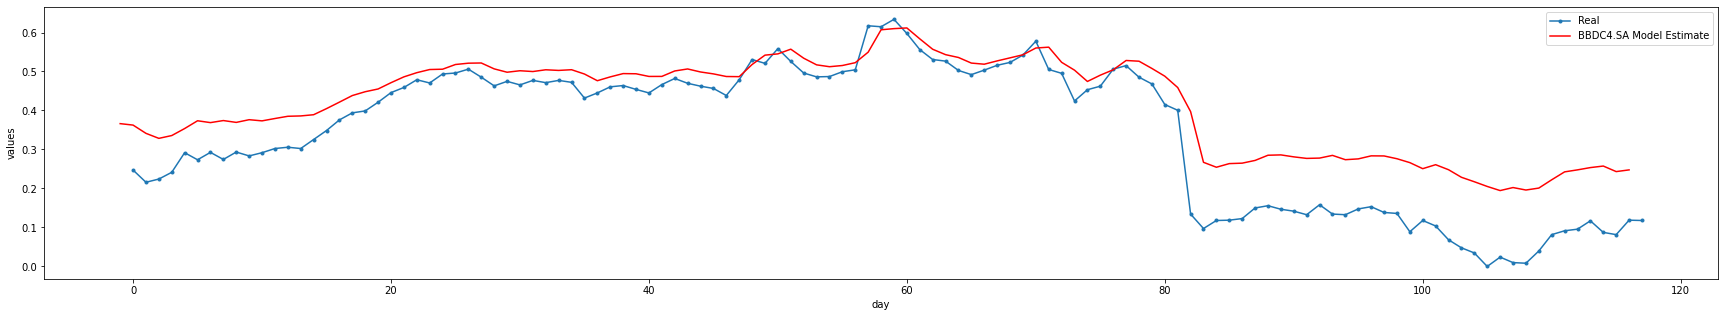

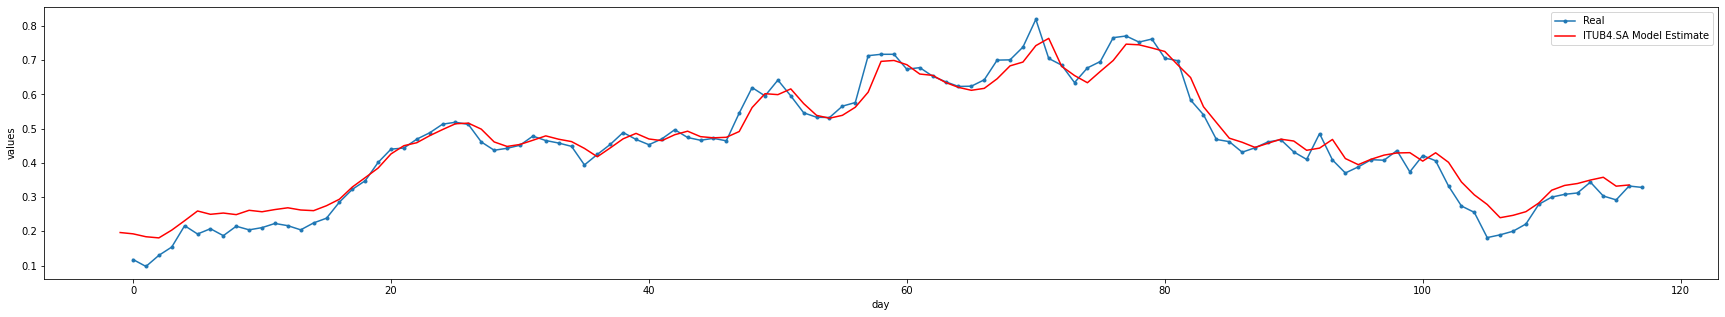

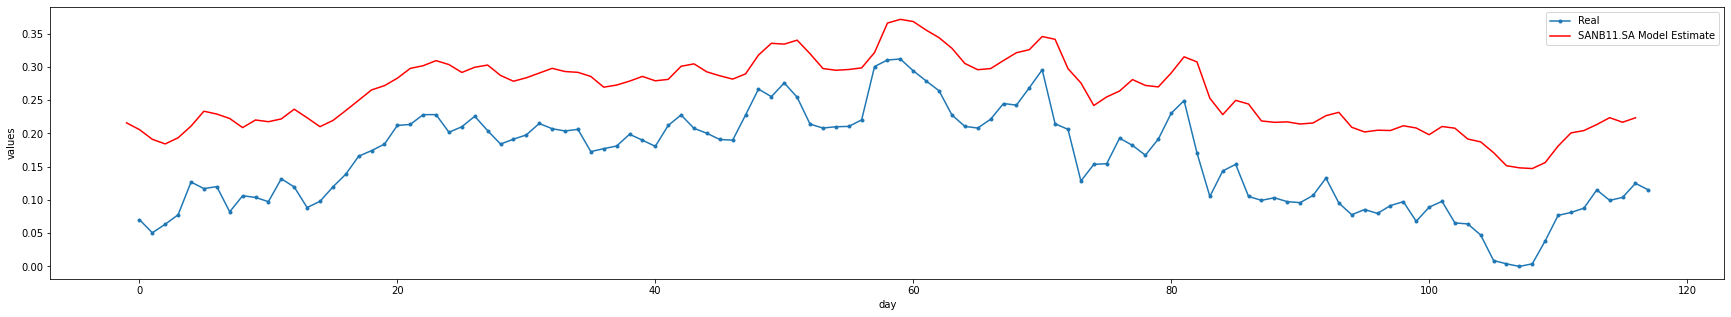

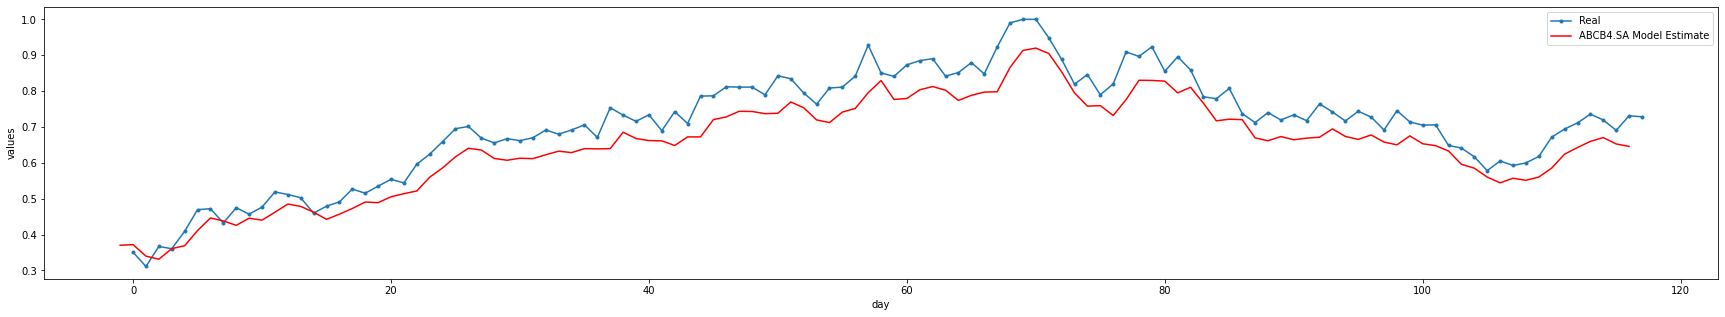

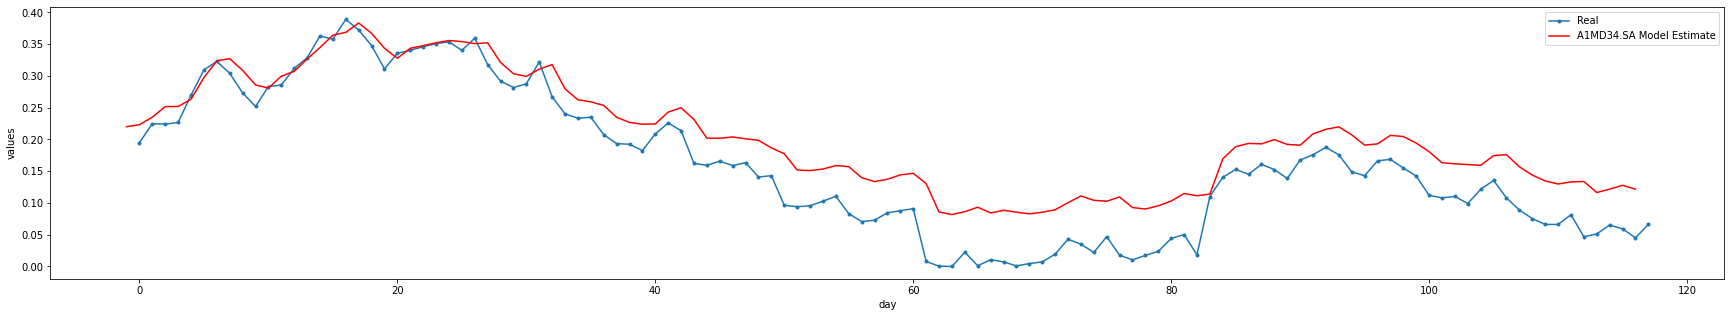

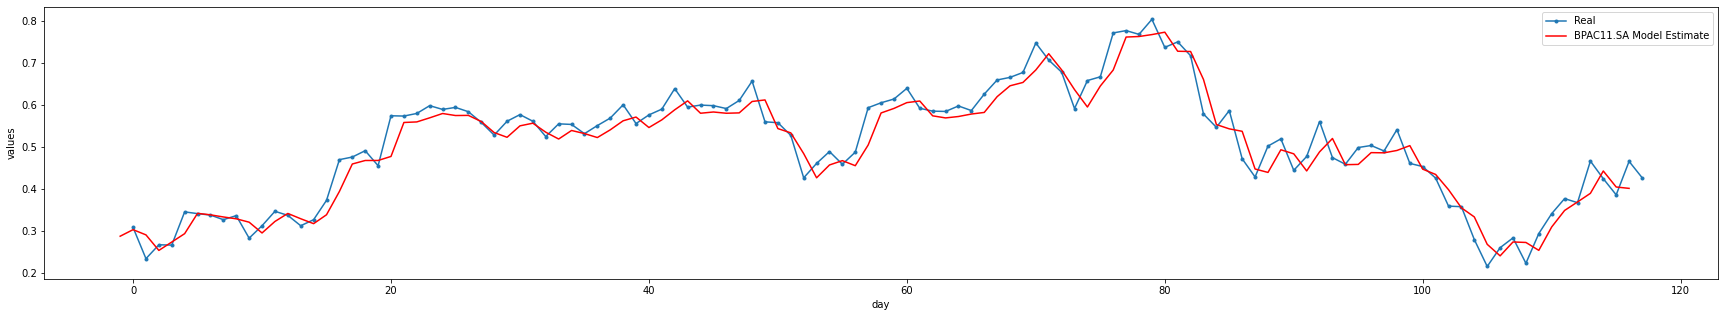

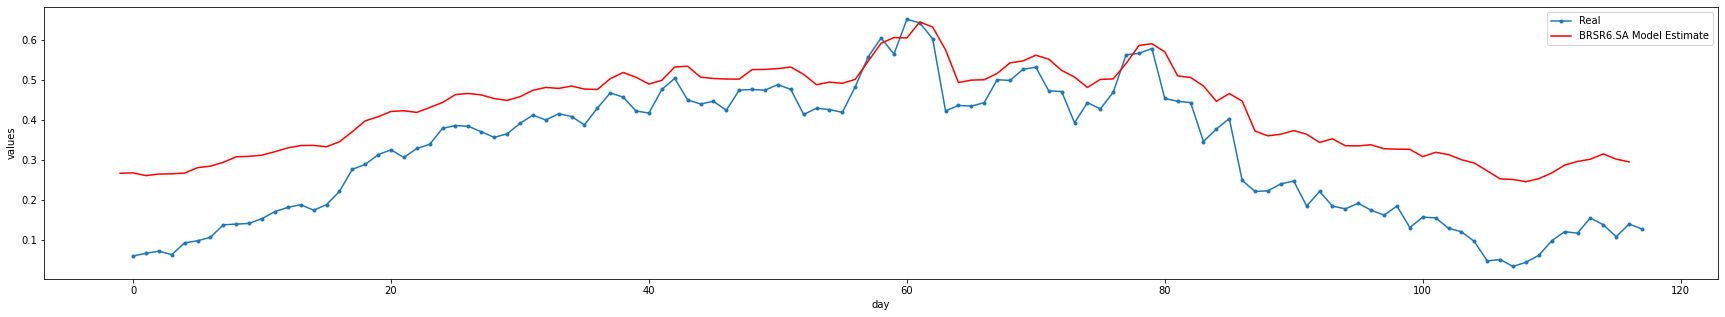

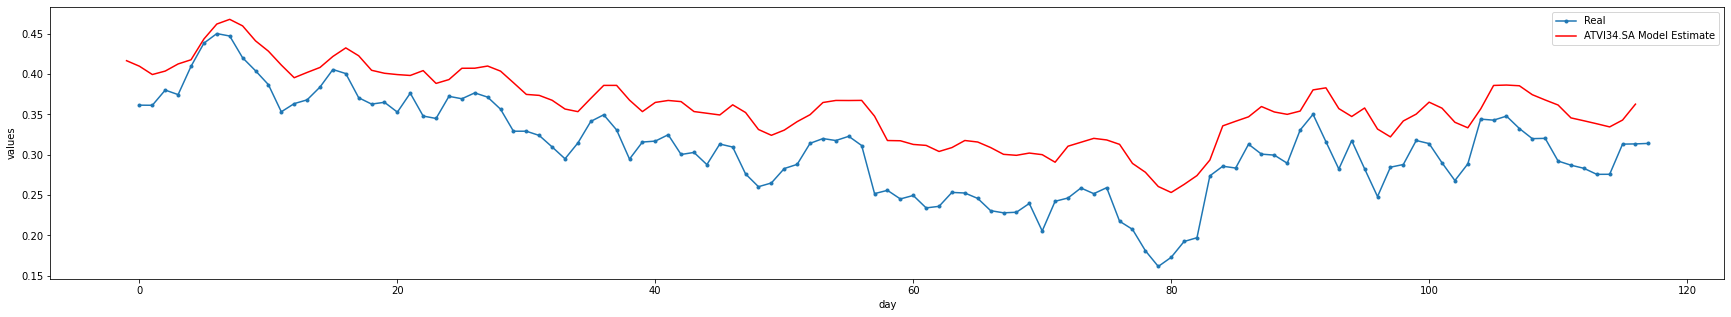

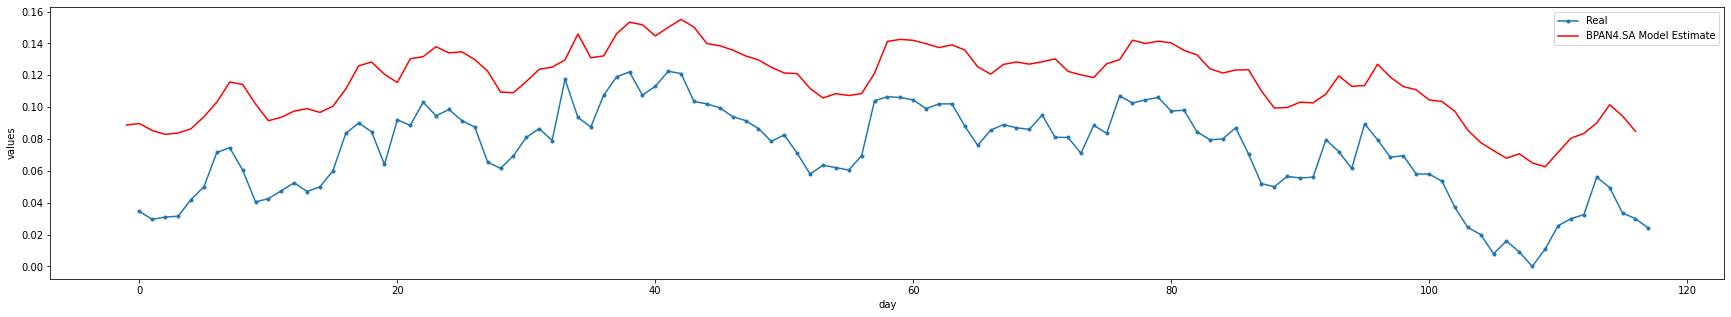

In [174]:
reais_y = {}
dados_prediçao = {}

for tickers in tickers_ativos:
  look_back = 1
  reais_y[tickers] = teste_y[tickers]
  plt.figure(figsize=(30,5))
  plt.plot(list(range(len(reais_y[tickers]))), 
          reais_y[tickers], 
          marker='.', 
          label='Real')
  dados_prediçao[tickers] = [w[0] for w in predição[tickers]]
  plt.plot(list(np.arange(len(predição[tickers]))-look_back), 
          dados_prediçao[tickers], 
          'r',label=f'{tickers} Model Estimate')
  plt.ylabel('values', size=10)
  plt.xlabel('day', size=10)
  plt.legend(fontsize=10)
  plt.show()

Observando o ganho de cada ativo

In [194]:
ganho = {}

for tickers in tickers_ativos:
  print('\n')
  la_manama = modelo[tickers].predict([teste_x[tickers][-1]])
  ganho[tickers] = (la_manama[1][0] - teste_x[tickers][-1][1][0]) / la_manama[1][0]
  print(f'{tickers}: \n hoje\'s value: {teste_x[tickers][-1][1][0]}  \n la manama: {la_manama[1][0]} \n ganho: {(ganho[tickers]) * 10:2.2f}%')



1/1 [==============================] - 0s 18ms/step
BBAS3.SA: 
 hoje's value: 0.4048750108294767  
 la manama: 0.13494734466075897 
 ganho: -20.00%


1/1 [==============================] - 0s 17ms/step
BBDC4.SA: 
 hoje's value: 0.11866943026454038  
 la manama: 0.11780431866645813 
 ganho: -0.07%


1/1 [==============================] - 0s 16ms/step
ITUB4.SA: 
 hoje's value: 0.33225270854322153  
 la manama: 0.13492414355278015 
 ganho: -14.63%


1/1 [==============================] - 0s 18ms/step
SANB11.SA: 
 hoje's value: 0.12493847791500223  
 la manama: 0.10358574986457825 
 ganho: -2.06%


1/1 [==============================] - 0s 18ms/step
ABCB4.SA: 
 hoje's value: 0.7311013120042376  
 la manama: 0.22230468690395355 
 ganho: -22.89%


1/1 [==============================] - 0s 17ms/step
A1MD34.SA: 
 hoje's value: 0.04505458973833836  
 la manama: 0.0641012191772461 
 ganho: 2.97%


1/1 [==============================] - 0s 16ms/step
BPAC11.SA: 
 hoje's value: 0.465659343898332 

Análise das ações

No espaço de tempo estudado, apenas 2 ativos se destacaram positivamente, muito pode ser dito por questões macro e microecônomicas do nosso país, se tratando dos bancos estudados. A imprevisibilidade na politicas de inflaçao e nas metas de juros.

Por fim será feito o problema da mochila

In [176]:
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
from mip import Model, maximize, xsum, BINARY, OptimizationStatus

In [187]:
coef_funcao_objetivo = list(ganho.values())
coef_restr = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
termo_independente = 3
     

Parametros da funçao 

In [188]:
funcao_objetivo=xsum(coef_funcao_objetivo[i] * x[i] for i in I)
funcao_objetivo

Por fim aplicando o modelo


In [189]:
size = range(len(coef_funcao_objetivo))
model = Model('pack')
mip_vars = [model.add_var(var_type=BINARY) for i in size]

In [190]:
função_objetivo = xsum(coef_funcao_objetivo[i] * mip_vars[i] for i in size)
model.objective = maximize(função_objetivo)

In [191]:
m += xsum(coef_restr[i] * x[i] for i in I) <= termo_independente
print(f'O modelo tem {m.num_cols} variável(eis), {m.num_rows} restrição(ões) e {m.num_nz} zero(s)')

O modelo tem 10 variável(eis), 10 restrição(ões) e 10 zero(s)


In [192]:
opt_status = model.optimize(max_seconds=10)
if opt_status == OptimizationStatus.OPTIMAL:
  print('V')
else:
  print('F')


V


In [193]:
selected = [list(ganho.keys())[i] for i in size if mip_vars[i].x >= 0.99]
print(f'Selected items: {selected}')
print(f'Optimal return: {model.objective_value}')

Selected items: ['A1MD34.SA', 'BPAN4.SA']
Optimal return: 0.7271519023510206
